<a href="https://colab.research.google.com/github/parseny/Generative-Models-2024/blob/assignment-1/Assignment%201/1_gan_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**Autumn 2024**


## Assignment 1

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR dataset.

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image

%matplotlib inline
plt.style.use("ggplot")

### Define parameters & data loading

In [21]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.73542482, -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.45516339,  0.58745098,  0.71973854,  0.85202616,
         0.98431373]),
 <BarContainer object of 15 artists>)

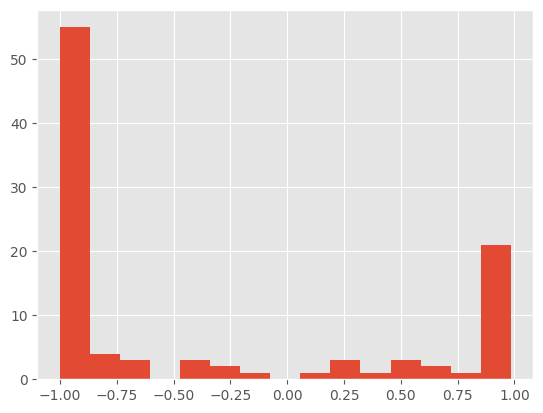

In [3]:
img, label = mnist_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [4]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
  return (x + 1) / 2


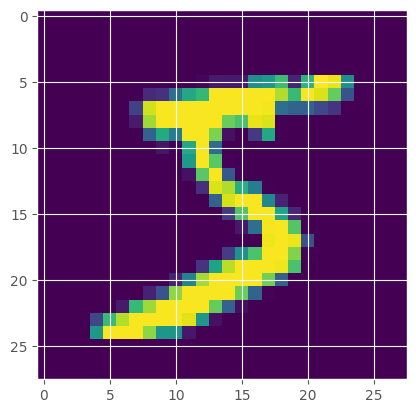

In [ ]:
# show image sample with matplotlib
imgplot = plt.imshow(denorm(img.squeeze(0)))

In [22]:
from torch.utils.data import DataLoader

# define the data_loader
data_loader = DataLoader(dataset=mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super(Generator, self).__init__()
        # set a linear layer with input size is latent_size and output size is hidden_size
        self.linear1 = nn.Linear(latent_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is image_size
        self.linear3 = nn.Linear(hidden_size, image_size)
        # self.relu = nn.ReLU()
        # self.tanh = nn.Tanh()

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> tanh
        x = nn.functional.relu(self.linear1(x))
        x = nn.functional.relu(self.linear2(x))
        x = nn.functional.tanh(self.linear3(x))
        return x


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        ## set a linear layer with input size is image_size and output size is hidden_size
        self.linear1 = nn.Linear(image_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is 1
        self.linear3 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.3)
        self.model = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> sigmoid
        # x = nn.functional.leaky_relu(self.linear1(x))
        # x = self.dropout(x)
        # x = nn.functional.leaky_relu(self.linear2(x))
        # x = self.dropout(x)
        # x = nn.functional.sigmoid(self.linear3(x))
        x = self.model(x)
        return x

### Create the Generator and Discriminator

In [23]:
# create new Generator model

G = Generator(latent_size, image_size, hidden_size)

# create new Discriminator model

D = Discriminator(image_size, hidden_size)

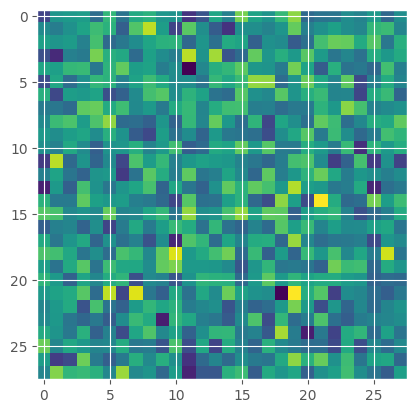

In [24]:
# show the output of model
y = G(torch.randn(1, latent_size))
plt.imshow(denorm(y).view(28, 28).detach().numpy())

In [26]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()

## Define the optimizer for generator and discrimator

optimizer_G = torch.optim.Adam(G.parameters(), lr=LR)

# Определение оптимизатора для дискриминатора
optimizer_D = torch.optim.Adam(D.parameters(), lr=LR)

Discriminator Training

In [25]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    optimizer_G.zero_grad()
    optimizer_D.zero_grad()

def train_discriminator(D_model, G_model, images):

    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)


    outputs = D_model(images)
    # Loss for real images
    real_loss = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G_model(z)
    outputs = D_model(fake_images)

    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    # Sum losses
    d_loss = real_loss + fake_loss
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    optimizer_D.step()
    # Adjust the parameters using backprop

    return d_loss, real_score, fake_score

Generator Training

In [18]:
def train_generator(G_model):
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1).to(device)
    # calculate the generator loss
    outputs = D(fake_images)
    g_loss = criterion(outputs, labels)
    # Reset gradients
    reset_grad()
    # Backprop and optimize
    g_loss.backward()
    optimizer_G.step()
    return g_loss, fake_images

### Start the training proccess

In [19]:
# function to save the sample output of generator
def save_fake_images_mnist(G_model, index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    fake_images = G_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [27]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(D, G, images)
        # Train the generator
        g_loss, fake_images = train_generator(G)
        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_mnist(G, epoch + 1)

Epoch [0/300], Step [200/600], d_loss: 0.1084, g_loss: 2.8882, D(x): 0.98, D(G(z)): 0.09
Epoch [0/300], Step [400/600], d_loss: 1.3707, g_loss: 0.8770, D(x): 0.78, D(G(z)): 0.60
Epoch [0/300], Step [600/600], d_loss: 0.7510, g_loss: 1.5206, D(x): 0.70, D(G(z)): 0.30
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.8795, g_loss: 1.0680, D(x): 0.70, D(G(z)): 0.38
Epoch [1/300], Step [400/600], d_loss: 0.3971, g_loss: 2.2756, D(x): 0.87, D(G(z)): 0.18
Epoch [1/300], Step [600/600], d_loss: 0.2834, g_loss: 2.4229, D(x): 0.93, D(G(z)): 0.15
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.3326, g_loss: 2.5243, D(x): 0.91, D(G(z)): 0.14
Epoch [2/300], Step [400/600], d_loss: 1.0252, g_loss: 2.1014, D(x): 0.67, D(G(z)): 0.22
Epoch [2/300], Step [600/600], d_loss: 0.7357, g_loss: 2.0763, D(x): 0.72, D(G(z)): 0.22
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.1710, g_loss: 3.2340, D(x): 0.95, D(G(z)): 0.09
Epoch [3/300], Step [400/6

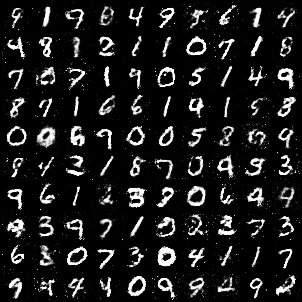

In [28]:
# show output after epochs training
Image.open(os.path.join(sample_dir, "fake_images-0225.png"))

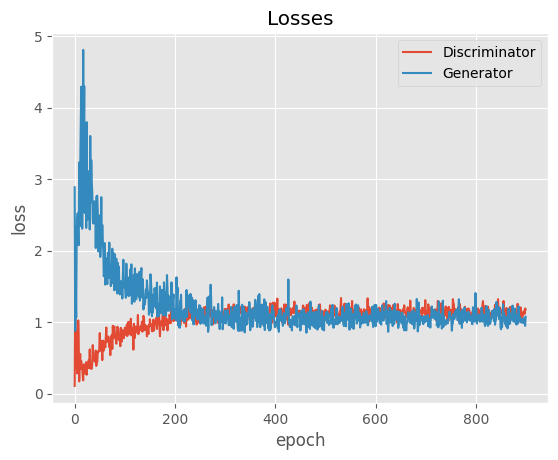

In [29]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

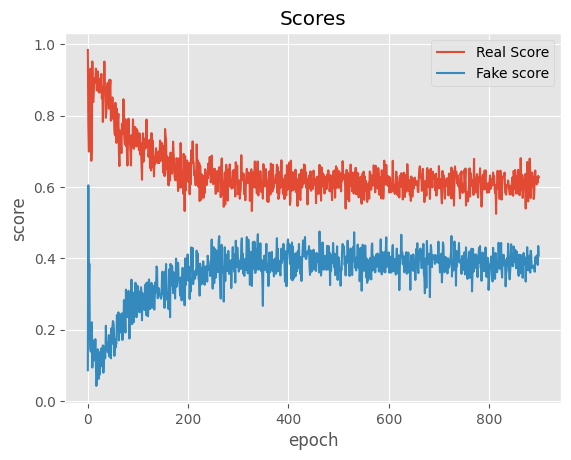

In [30]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [ ]:
class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

In [ ]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [ ]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    # write your code

# show  image sample with matplotlib


In [ ]:
# create the data_loader

### DCGAN implementation

In [ ]:
class DCGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
        # ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu
        # ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(Generator, self).__init__()
        ##

    def forward(self, x):
        ##
        return F.tanh(x)


class DCDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        # conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(Discriminator, self).__init__()
        ##

    def forward(self, x):
        ##
        return F.sigmoid(x)

In [ ]:
# create new Generator model

# DCG = DCGenerator...

# create new Discriminator model

# DCD = DCDiscriminator...

In [ ]:
# show the output of model
y = DCG(torch.randn(2, CFG.nz))

In [ ]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator

In [ ]:
# feel free to reuse your training functions

### Start the training proccess

In [ ]:
def save_fake_images_cifar(DCG_model, index):
    sample_vectors = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = DCG_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10
    )

In [ ]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
DCG.to(device)
DCD.to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator

        # Train the generator

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_cifar(epoch + 1)

In [ ]:
# show your results!